# Introduction 
This notebook demonstrates the Metropolis-Hastings Markov Chain Monte Carlo (MH-MCMC) process applied to partial orders.

a) Starting with a given partial order, we sample corresponding total orders.

b) Using the sampled total orders from part (a), we infer the original partial order.

For this analysis, we utilize several utility functions located in utils/po_fun.py and utils/po_fun_plot.py. Additionally, the MH-MCMC implementation is provided in the po_mcmc.py source code file.


In [3]:
import sys
# Add the path to the src directory to access utility modules and po_hm_mcmc.py
sys.path.append('../src')  # Adjust the path if your directory structure is different
 
sys.path.append('../src/utils')  # Ensure this path points to the directory containing your utility modules

from po_fun import BasicUtils, StatisticalUtils,GenerationUtils
from po_fun_plot import PO_plot 
from po_accelerator import LogLikelihoodCache 
from po_hm_mcmc_all import mcmc_partial_order

 # Adjust this path based on your directory structure
# Import necessary libraries
import numpy as np
import networkx as nx
import random
import itertools
import matplotlib.pyplot as plt
import pygraphviz as pgv
from typing import List, Dict, Any
import seaborn as sns 
from scipy.stats import beta

import yaml
with open("/home/doli/Desktop/research/coding/BayesianPartialOrders/mcmc_config.yaml", "r") as f:
    config = yaml.safe_load(f)

## Generate the partial order h given the prior parameters of rho 


### Generating a Partial Order
We generate a partial order using the `generate_random_PO` function and provide the basic description of the PO.
#### Comments on Generating Samples from a Given Partial Order:

- **Setting the Parameter `N`:**
  - The value of `N` should be chosen thoughtfully to ensure the quality of the MCMC sampling.


In [ ]:
n = 8
N= 35 
K=config["mcmc"]["K"]
rho_prior = config["prior"]["rho_prior"]
noise_option = config["noise"]["noise_option"]
mallow_ua = config["prior"]["mallow_ua"]
items = list(range(n))
rho_true=beta.rvs(1,rho_prior)


U = GenerationUtils.generate_U(n, K, rho_true)
print("U matrix (latent positions):")
print(U)
h = BasicUtils.generate_partial_order(U)
h_true=BasicUtils.transitive_reduction(h.copy())
print("\nPartial Order (adjacency matrix):")
print(h_true)


U matrix (latent positions):
[[-0.77840503 -0.3155712  -0.80821752 -0.34112845 -0.8795857 ]
 [ 1.28036819  1.39840803  1.26006862  1.7781907   1.24620808]
 [ 0.38378087  0.46771558  0.62281262  0.24717321  0.54593813]
 [ 1.14192377  0.78793683  1.07465216  0.60761897  0.39519052]
 [ 0.71959455  0.60608513  0.55212992  0.22756334 -0.2391615 ]]

Partial Order (adjacency matrix):
[[0 0 0 0 0]
 [0 0 1 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]


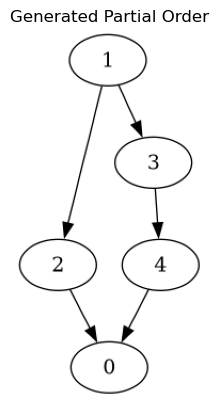

The targeted partial order h is : [[0 0 0 0 0]
 [0 0 1 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]]

--- Partial Order Description ---
Number of Nodes: 5
Number of Relationships: 5
Number of Alone Nodes: 0
Alone Nodes: []
Maximum In-Degree: 2
Maximum Out-Degree: 2
Maximum Relationships per Node: 2
Number of Linear Extensions: 3
Depth of Partial Order: 3
---------------------------------


In [5]:
PO_plot.visualize_partial_order(BasicUtils.transitive_reduction(h_true), items,title='Generated Partial Order')
print(f"The targeted partial order h is : {h_true}")

StatisticalUtils.description_partial_order(h_true)

## B) Generate the distribution  of the list withthe queue jump error:
- **Given a subset**, we sample a subset, then given the subset
- **In the end**, we provide statistics of the total orders.

In [6]:
items = list(range(n))
item_to_index = {item: idx for idx, item in enumerate(items)}

subsets = GenerationUtils.generate_subsets(N, n)
print(subsets)
## we generate the queue jump noise total order for each subset


[[2, 3, 4], [0, 1, 2, 4], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0, 3], [0, 1], [0, 1, 2, 3, 4], [0, 3, 4], [0, 3, 4], [3, 4]]


In [7]:
h_tc=BasicUtils.transitive_closure(h)
noise_beta_prior = config["prior"]["noise_beta_prior"] 
prob_noise = StatisticalUtils.rPprior(noise_beta_prior)
prob_noise_true=prob_noise

total_orders = []
for choice_set in subsets:
    if noise_option == "queue_jump":
        y_generated = StatisticalUtils.generate_total_order_for_choice_set_with_queue_jump(choice_set, items,h_tc, prob_noise)

    elif noise_option == "mallows_noise":
        y_generated = StatisticalUtils.generate_total_order_for_choice_set_with_mallow_noise(choice_set,items, h_tc,  mallow_ua)
    total_orders.append(y_generated)


Top 15 Most Frequent Total Orders:
         Total Order  Frequency
0          3 > 4 > 0          2
1          4 > 3 > 2          1
2      2 > 1 > 4 > 0          1
3  1 > 3 > 4 > 2 > 0          1
4  1 > 2 > 3 > 0 > 4          1
5              3 > 0          1
6              1 > 0          1
7  1 > 3 > 2 > 4 > 0          1
8              4 > 3          1


/home/doli/Desktop/research/coding/BayesianPartialOrders/notebooks/../src/utils/po_fun_plot.py:275: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


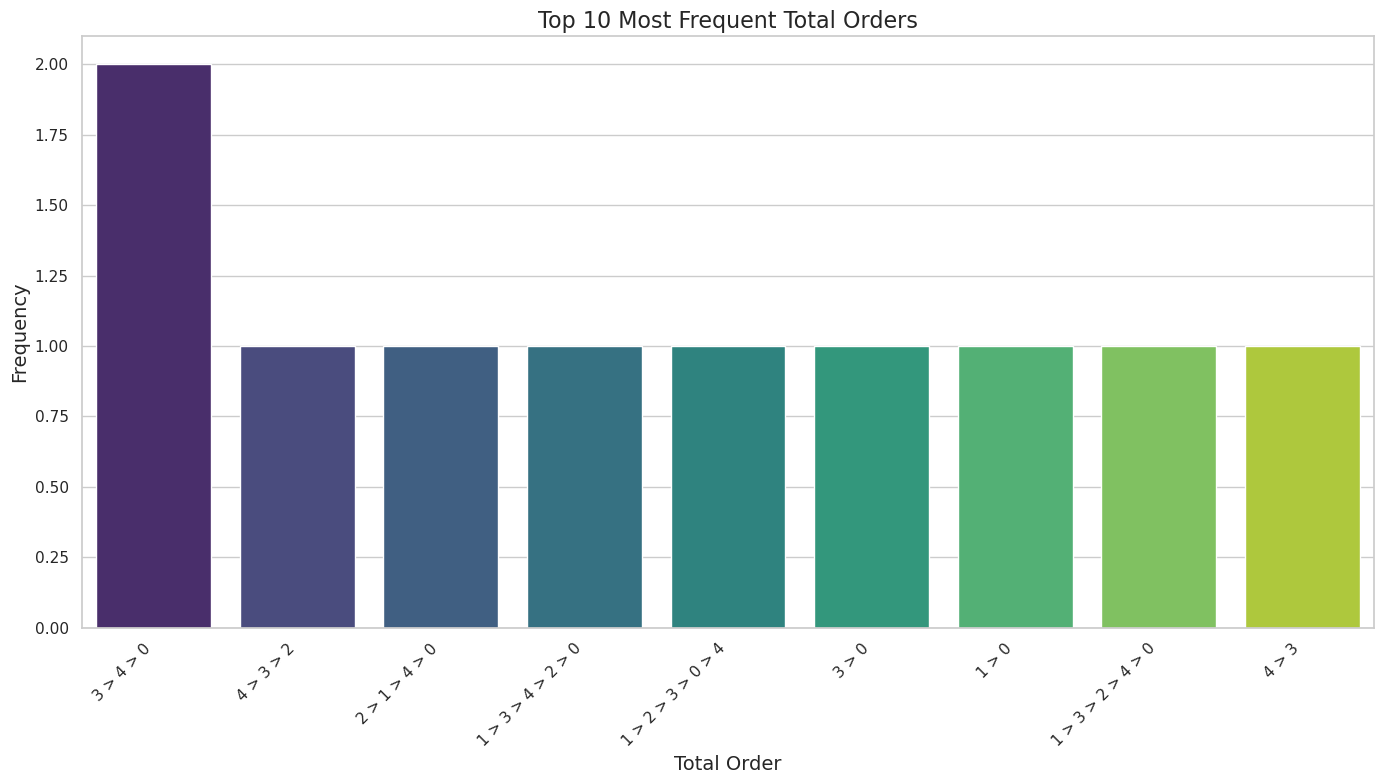

In [8]:
PO_plot.visualize_total_orders(total_orders, top_print=15, top_plot=10)

## b) MCMC Simulation 

We want to performa the MCMC simulation to infer the h 
- h is caclualted from taking the mean of the h_trace
- we also curious abou the distribution for the h_trace 
- We will check the simulated h and the defined-h and they should be the same 

In [9]:
num_iterations = config["mcmc"]["num_iterations"]
K = config["mcmc"]["K"]
mcmc_pt = [
    config["mcmc"]["update_probabilities"]["rho"],
    config["mcmc"]["update_probabilities"]["noise"],
    config["mcmc"]["update_probabilities"]["U"]
]
dr = config["rho"]["dr"]

noise_option = config["noise"]["noise_option"]
sigma_mallow = config["noise"]["sigma_mallow"]

noise_beta_prior = config["prior"]["noise_beta_prior"]
mallow_ua = config["prior"]["mallow_ua"]

mallow_theta_true=1

mcmc_results = mcmc_partial_order(
    total_orders,
    subsets,
    num_iterations,
    K,
    dr,
    sigma_mallow,
    noise_option,
    mcmc_pt,
    rho_prior, 
    noise_beta_prior,
    mallow_ua
)

print("MCMC run complete. Returned keys:")
print(mcmc_results.keys())

Iteration 10000/100000 - Accept Rate: 58.20%
Iteration 20000/100000 - Accept Rate: 59.62%
Iteration 30000/100000 - Accept Rate: 58.83%
Iteration 40000/100000 - Accept Rate: 58.50%
Iteration 50000/100000 - Accept Rate: 58.38%
Iteration 60000/100000 - Accept Rate: 58.47%
Iteration 70000/100000 - Accept Rate: 58.44%
Iteration 80000/100000 - Accept Rate: 58.55%
Iteration 90000/100000 - Accept Rate: 58.53%
Iteration 100000/100000 - Accept Rate: 57.38%

Overall Acceptance Rate after 100000 iterations: 57.38%
MCMC run complete. Returned keys:
dict_keys(['Z_trace', 'h_trace', 'index_to_item', 'item_to_index', 'rho_trace', 'prob_noise_trace', 'mallow_theta_trace', 'proposed_rho_vals', 'proposed_prob_noise_vals', 'proposed_mallow_theta_vals', 'proposed_Zs', 'acceptance_rates', 'acceptance_decisions', 'log_likelihood_currents', 'log_likelihood_primes', 'overall_acceptance_rate'])


In [10]:
h_final=np.mean(mcmc_results['h_trace'],axis=0)

threshold=0.5
index_to_item = mcmc_results['index_to_item']
iterations = list(range(1, num_iterations + 1))

h_final_inferred=BasicUtils.transitive_reduction(h_final>=threshold).astype(int)


print("Final adjacency (thresholded):")
print(h_final_inferred)

Final adjacency (thresholded):
[[0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]


### Visulise for the h_trace and Z_Trace from the MCMC 

Partial Order 1:
[[0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]
Count: 129

Partial Order 2:
[[0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]
Count: 120

Partial Order 3:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Count: 85

Partial Order 4:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]
Count: 81

Partial Order 5:
[[0 0 0 0 0]
 [1 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]
Count: 60

Partial Order 6:
[[0 0 0 0 0]
 [1 0 0 0 1]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]
Count: 56

Partial Order 7:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]
Count: 53

Partial Order 8:
[[0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Count: 41

Partial Order 9:
[[0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Count: 27

Partial Order 10:
[[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]
Count: 24

Partial Order 11:
[[0 0 0 0 0]
 [1 0 0 1 1]
 [0 0 0 0 0]


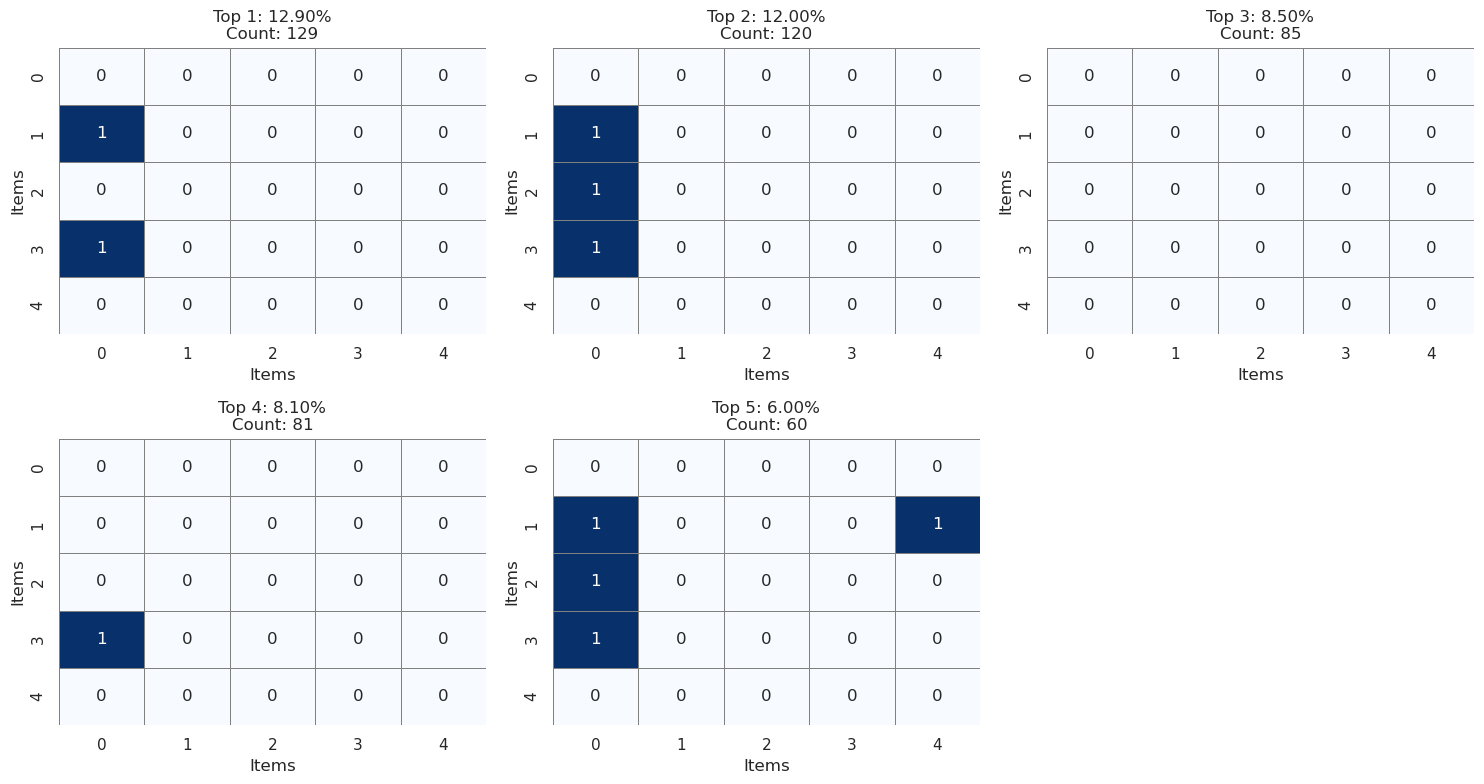

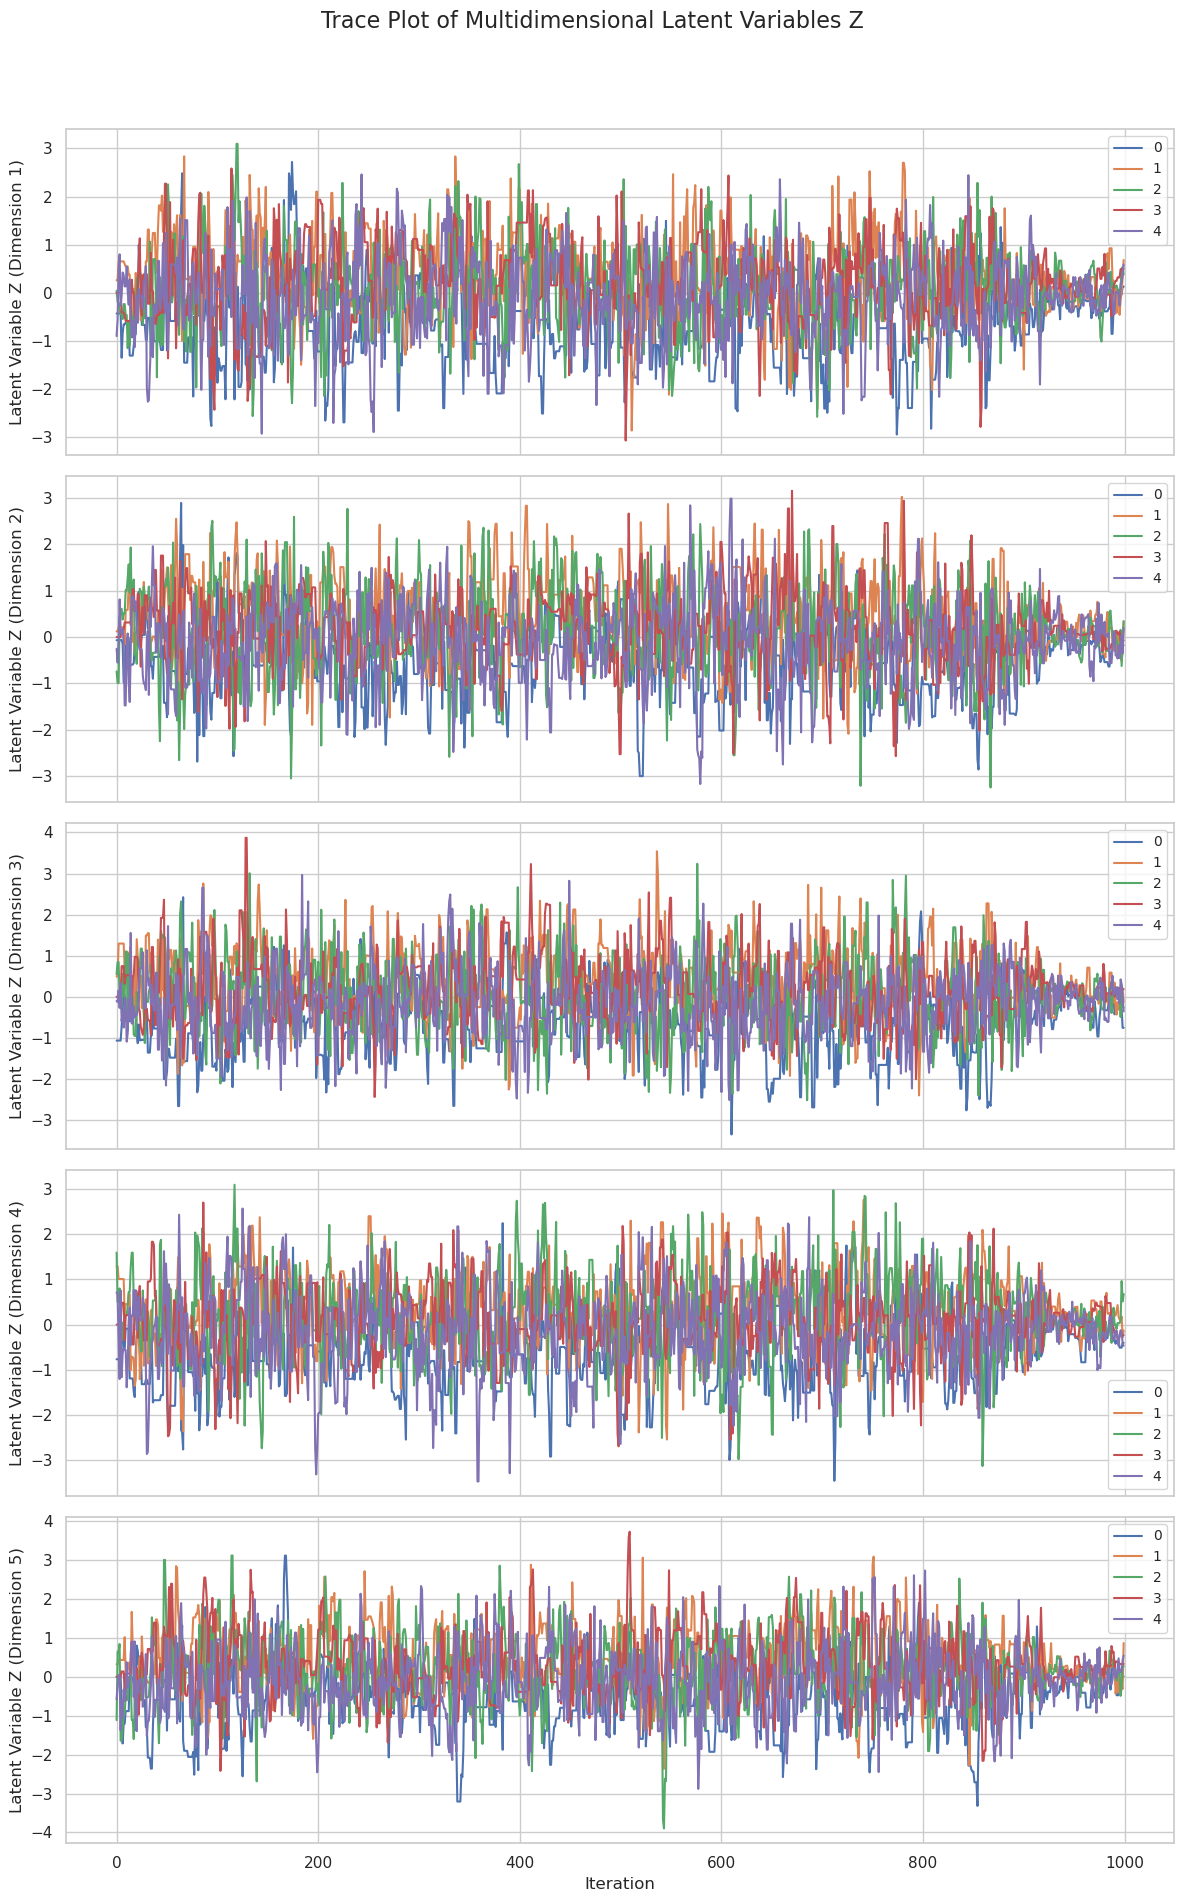

[[0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]


In [11]:
# Example usage
sorted_unique_orders = StatisticalUtils.count_unique_partial_orders(mcmc_results['h_trace'])

# Print the sorted partial orders with their counts
for idx, (order, count) in enumerate(sorted_unique_orders, 1):
    print(f"Partial Order {idx}:\n{order}\nCount: {count}\n")

total_samples = sum(count for _, count in sorted_unique_orders)
print(f"Total number of samples in h_trace: {total_samples}\n")
top_n = 5
top_partial_orders = sorted_unique_orders[:top_n]
top_percentages = [(order, count, (count / total_samples) * 100) for order, count in top_partial_orders]

items = sorted(set(itertools.chain.from_iterable(total_orders)))
n = len(items)
item_labels = items  # ['A', 'B', 'C']
# Plot the top 5 partial orders
PO_plot.plot_top_partial_orders(top_percentages, top_n=top_n, item_labels=item_labels)

PO_plot.plot_Z_trace(mcmc_results['Z_trace'],index_to_item)
print(h_final_inferred)

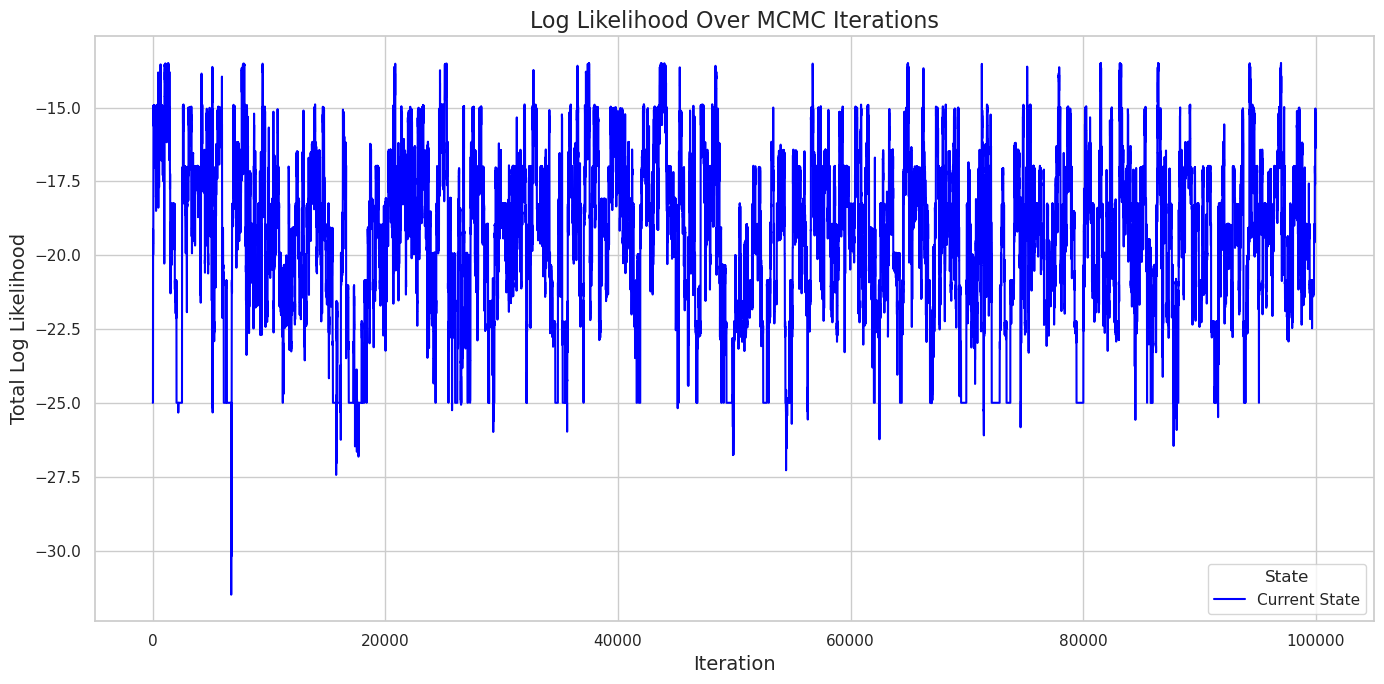

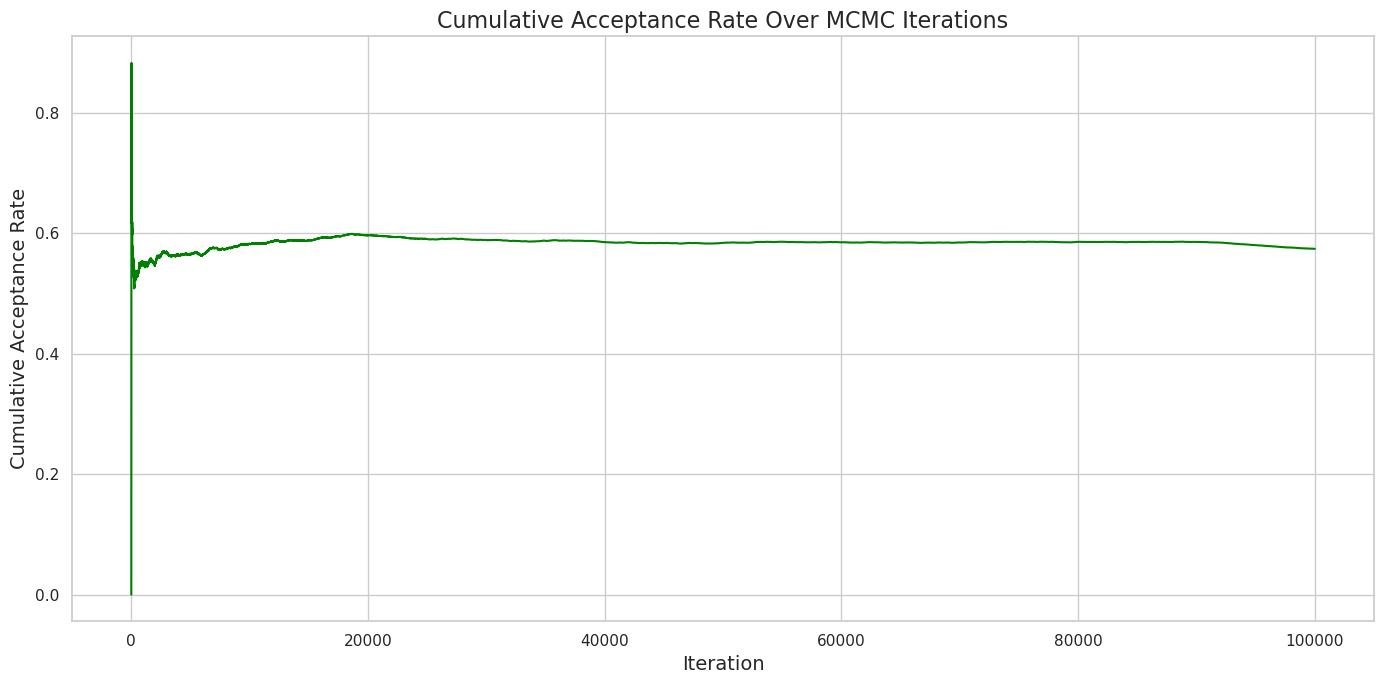

In [12]:
PO_plot.plot_log_likelihood(mcmc_results, title='Log Likelihood Over MCMC Iterations')
PO_plot.plot_acceptance_rate(mcmc_results['acceptance_rates'], num_iterations)

### Inferred h comparison 
In the end, we want to compare the simulated h and the true h, especially the missing relationship between items.

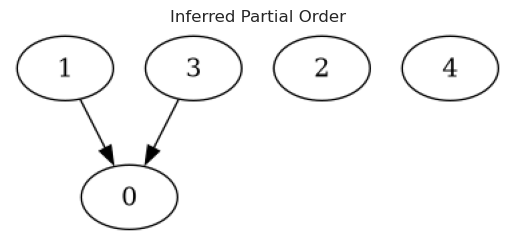

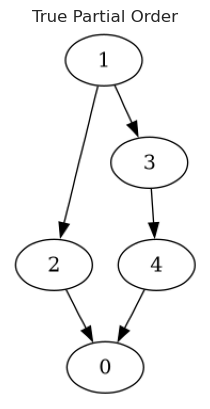


Missing Relationships (edges present in true PO but absent in inferred PO):
1 < 2
1 < 3
2 < 0
3 < 4
4 < 0

Redundant Relationships (edges present in inferred PO but absent in true PO):
1 < 0
3 < 0


In [13]:
def compute_missing_relationships(h_true: np.ndarray, h_final: np.ndarray, index_to_item: Dict[int, int]) -> List[tuple]:
    """
    Compute the missing relationships between the true partial order and the inferred partial order.
    
    Parameters:
    - h_true (np.ndarray): Adjacency matrix of the true partial order.
    - h_final (np.ndarray): Adjacency matrix of the inferred partial order.
    - index_to_item (Dict[int, int]): Mapping from index to item.
    
    Returns:
    - List[tuple]: List of tuples representing the missing relationships (i, j).
    """
    missing = []
    n = h_true.shape[0]
    for i in range(n):
        for j in range(n):
            if h_true[i, j] == 1 and h_final[i, j] == 0:
                missing.append( (index_to_item[i], index_to_item[j]) )
    return missing




def compute_redundant_relationships(h_true: np.ndarray, h_final: np.ndarray, index_to_item: Dict[int, int]) -> List[tuple]:
    """
    Compute the redundant relationships in the inferred partial order not present in the true partial order.
    
    Parameters:
    - h_true (np.ndarray): Adjacency matrix of the true partial order.
    - h_final (np.ndarray): Adjacency matrix of the inferred partial order.
    - index_to_item (Dict[int, int]): Mapping from index to item.
    
    Returns:
    - List[tuple]: List of tuples representing the redundant relationships (i, j).
    """
    redundant = []
    n = h_true.shape[0]
    for i in range(n):
        for j in range(n):
            if h_true[i, j] == 0 and h_final[i, j] == 1:
                redundant.append( (index_to_item[i], index_to_item[j]) )
    return redundant

# Plot Inferred Partial Order
PO_plot.visualize_partial_order(
    final_h=h_final_inferred,
    Ma_list=items, 
    title='Inferred Partial Order',
)

# Plot True Partial Order and Inferred Partial Order
PO_plot.visualize_partial_order(
    final_h=BasicUtils.transitive_reduction(h_true),
    Ma_list=items, 
    title='True Partial Order',
)

missing_relationships = compute_missing_relationships(h_true, h_final_inferred, index_to_item)
redundant_relationships= compute_redundant_relationships(h_true, h_final_inferred, index_to_item)
if missing_relationships:
    print("\nMissing Relationships (edges present in true PO but absent in inferred PO):")
    for i, j in missing_relationships:
        print(f"{i} < {j}")
else:
    print("\nNo missing relationships. The inferred partial order matches the true partial order.")

if redundant_relationships:
    print("\nRedundant Relationships (edges present in inferred PO but absent in true PO):")
    for i, j in redundant_relationships:
        print(f"{i} < {j}")
else:
    print("\nNo redundant relationships. The inferred partial order is a subset of the true partial order.")

In [14]:
mallow_theta_true = 1/(1+mallow_ua)
tau_true=1
true_param = {
    "rho_true": rho_true,
    "prob_noise_true": prob_noise_true,
    "mallow_theta_true": mallow_theta_true,
    "tau_true": tau_true,
}
tau_true=1
mcmc_results["tau_trace"]=[]


[INFO] Saved MCMC parameter plots to 'mcmc_inferred_result.pdf'


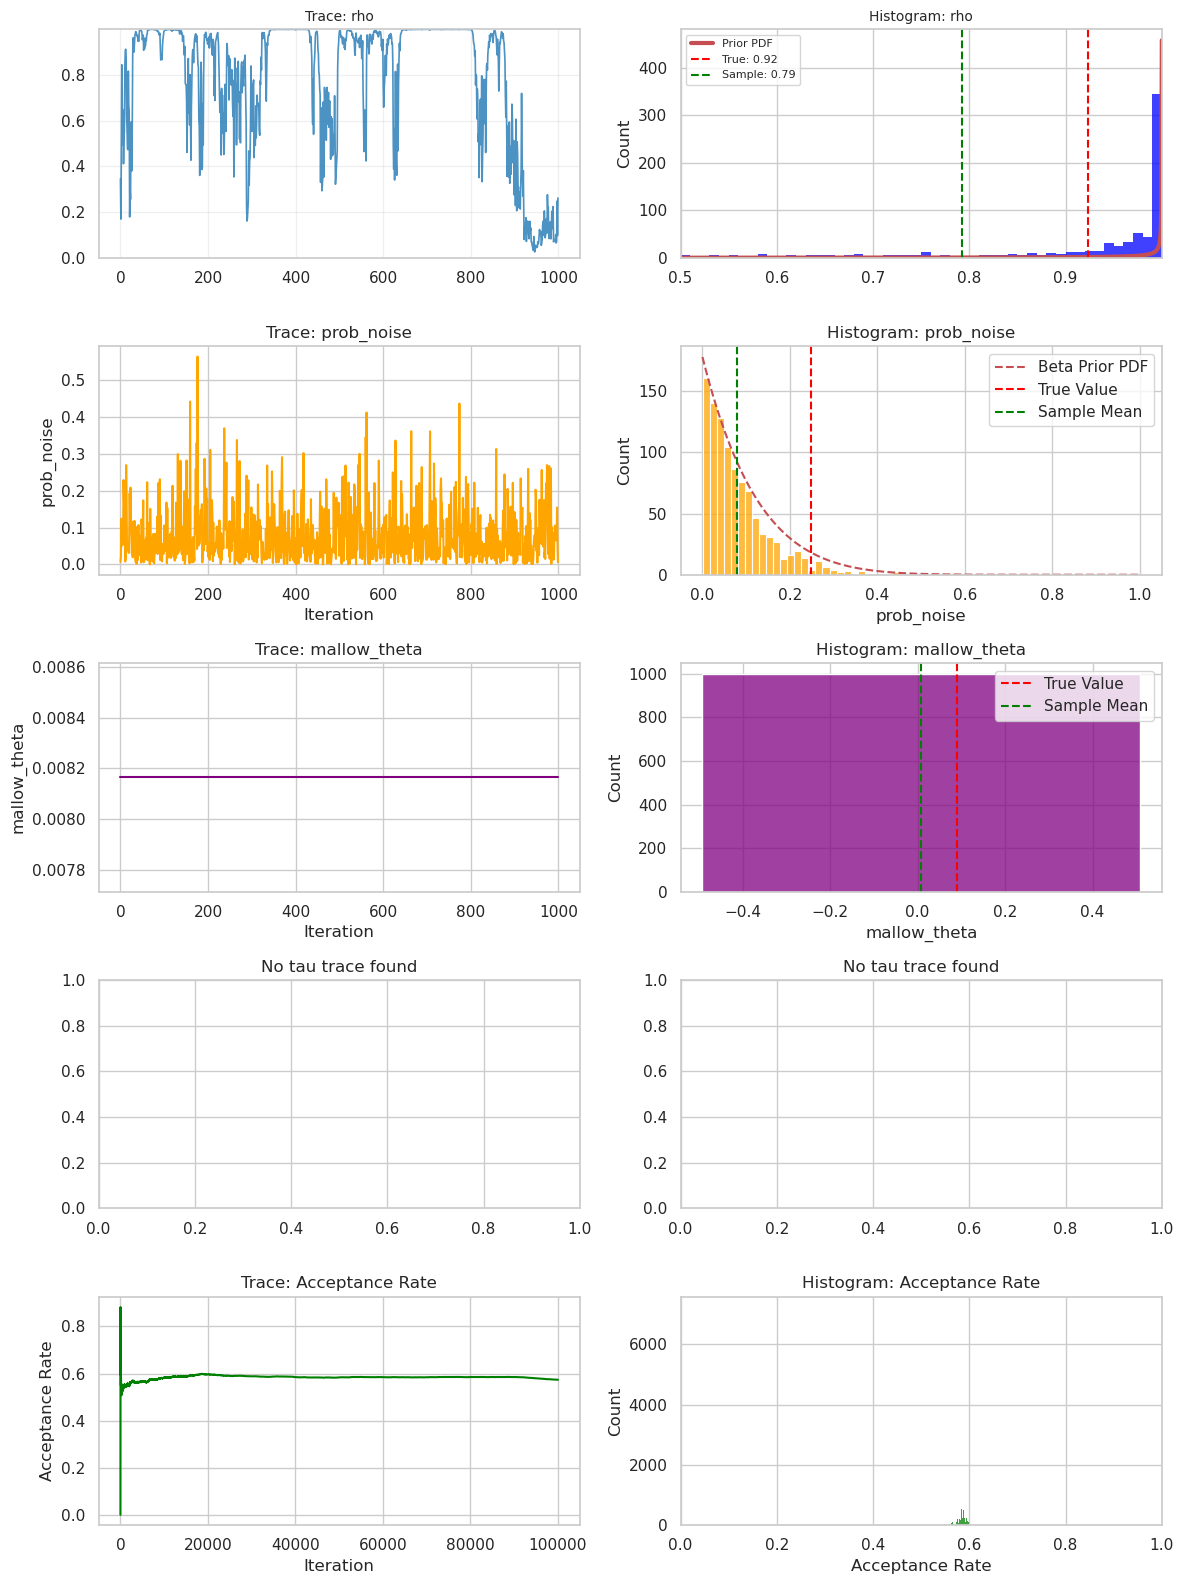

[INFO] No U0_trace in mcmc_results; skipping U0[0,0] plot.
[INFO] No Ua_trace or no assessors or M_a_dict; skipping local U-plot.


In [15]:
PO_plot.plot_mcmc_inferred_variables(
    mcmc_results,
    true_param,
    config,
    output_filename="mcmc_inferred_result.pdf"
)
